In [111]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
import sys
import os

In [112]:
from wordcloud import WordCloud
from translate import Translator
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

In [113]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 40)
sns.set_theme(style="white")
mpl.rc('font', family='Calibri')

In [114]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [115]:
warehouse_location = "hdfs://m1.local.br:9000/user/hive/warehouse"
hive_metastore_uri = "thrift://m1.local.br:9083"
defaultFS = "hdfs://m1.local.br:9000"

# 1 - Conectando ao Hive com PySpark

In [116]:
spark = SparkSession.builder \
    .appName("Machine Learning - MovieLens dataset") \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .config("spark.hadoop.fs.defaultFS", defaultFS) \
    .config("hive.metastore.uris", hive_metastore_uri) \
    .enableHiveSupport() \
    .getOrCreate()

spark

In [117]:
spark.catalog.refreshByPath(warehouse_location)

In [118]:
print("URI do Metastore do Hive:", spark.conf.get("hive.metastore.uris"))
print("Endereço do Hadoop (HDFS):", spark.conf.get("spark.hadoop.fs.defaultFS"))

URI do Metastore do Hive: thrift://m1.local.br:9083
Endereço do Hadoop (HDFS): hdfs://m1.local.br:9000


In [64]:
# Visualizando todos os datasets
databases = spark.sql("show databases")
databases.show()

+----------------+
|       namespace|
+----------------+
|         default|
|     flight_data|
|hpc_treinamentos|
|      myhivebook|
+----------------+



In [65]:
# Visualizando o nome do usuário
tables = spark.sql("SELECT current_user()")
tables.show()

+--------------+
|current_user()|
+--------------+
| Vinicius Luiz|
+--------------+



In [66]:
# Se conectando ao banco default
spark.sql("USE default")

DataFrame[]

In [67]:
# Visualizando as tabelas no database default
tables = spark.sql("SHOW tables")
tables.show()

+---------+-----------------+-----------+
|namespace|        tableName|isTemporary|
+---------+-----------------+-----------+
|  default|    genome_scores|      false|
|  default|genome_scores_tmp|      false|
|  default|      genome_tags|      false|
|  default|  genome_tags_tmp|      false|
|  default|            links|      false|
|  default|        links_tmp|      false|
|  default|           movies|      false|
|  default|       movies_tmp|      false|
|  default|          ratings|      false|
|  default|      ratings_tmp|      false|
|  default|             tags|      false|
|  default|         tags_tmp|      false|
+---------+-----------------+-----------+



In [68]:
SQL_COUNT = '''
select count(1)       as qtd_linhas
    , 'genome_scores' as table_name
  from genome_scores
union all
select count(1)       as qtd_linhas
    , 'genome_tags'   as table_name
  from genome_tags
union all
select count(1)       as qtd_linhas
    , 'movies'        as table_name
  from movies
union all
select count(1)       as qtd_linhas
    , 'ratings'       as table_name
  from ratings
union all
select count(1)       as qtd_linhas
    , 'tags'          as table_name
  from tags
union all
select count(1)       as qtd_linhas
    , 'links'         as table_name
  from links
'''

In [69]:
df_movies = spark.sql(SQL_COUNT)
df_movies.show(10, truncate=False)

+----------+-------------+
|qtd_linhas|table_name   |
+----------+-------------+
|18472128  |genome_scores|
|1128      |genome_tags  |
|86537     |movies       |
|33832162  |ratings      |
|2328315   |tags         |
|86537     |links        |
+----------+-------------+



# 2 - Schema das tabelas

## Movies

In [70]:
df_movies = spark.sql('SELECT * FROM movies')
df_movies.show(5, truncate=False)

+-------+----------------------------------+----+-------------------------------------------------+
|movieid|title                             |year|genres                                           |
+-------+----------------------------------+----+-------------------------------------------------+
|1      |Toy Story (1995)                  |1995|[Adventure, Animation, Children, Comedy, Fantasy]|
|2      |Jumanji (1995)                    |1995|[Adventure, Children, Fantasy]                   |
|3      |Grumpier Old Men (1995)           |1995|[Comedy, Romance]                                |
|4      |Waiting to Exhale (1995)          |1995|[Comedy, Drama, Romance]                         |
|5      |Father of the Bride Part II (1995)|1995|[Comedy]                                         |
+-------+----------------------------------+----+-------------------------------------------------+
only showing top 5 rows



In [71]:
df_movies.printSchema()

root
 |-- movieid: long (nullable = true)
 |-- title: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: string (containsNull = true)



## Ratings

In [72]:
df_ratings = spark.sql('SELECT * FROM ratings')
df_ratings.show(5, truncate=False)

+------+-------+------+----------------+-------------------+
|userid|movieid|rating|rating_timestamp|rating_date        |
+------+-------+------+----------------+-------------------+
|1     |1      |4.0   |1225734739      |2008-11-03 17:52:19|
|1     |110    |4.0   |1225865086      |2008-11-05 06:04:46|
|1     |158    |4.0   |1225733503      |2008-11-03 17:31:43|
|1     |260    |4.5   |1225735204      |2008-11-03 18:00:04|
|1     |356    |5.0   |1225735119      |2008-11-03 17:58:39|
+------+-------+------+----------------+-------------------+
only showing top 5 rows



In [73]:
df_ratings.printSchema()

root
 |-- userid: string (nullable = true)
 |-- movieid: long (nullable = true)
 |-- rating: decimal(10,1) (nullable = true)
 |-- rating_timestamp: long (nullable = true)
 |-- rating_date: timestamp (nullable = true)



## Tags

In [74]:
df_tags = spark.sql('SELECT * FROM tags')
df_tags.show(5, truncate=False)

+------+-------+-------------+-------------+-------------------+
|userid|movieid|tag          |tag_timestamp|tag_date           |
+------+-------+-------------+-------------+-------------------+
|10    |260    |good vs evil |1430666558   |2015-05-03 15:22:38|
|10    |260    |Harrison Ford|1430666505   |2015-05-03 15:21:45|
|10    |260    |sci-fi       |1430666538   |2015-05-03 15:22:18|
|14    |1221   |Al Pacino    |1311600756   |2011-07-25 13:32:36|
|14    |1221   |mafia        |1311600746   |2011-07-25 13:32:26|
+------+-------+-------------+-------------+-------------------+
only showing top 5 rows



In [75]:
df_tags.printSchema()

root
 |-- userid: string (nullable = true)
 |-- movieid: long (nullable = true)
 |-- tag: string (nullable = true)
 |-- tag_timestamp: long (nullable = true)
 |-- tag_date: timestamp (nullable = true)



## Links

In [76]:
df_links = spark.sql('SELECT * FROM links')
df_links.show(5, truncate=False)

+-------+-------+------+
|movieid|imbdid |tmdbid|
+-------+-------+------+
|1      |0114709|862   |
|2      |0113497|8844  |
|3      |0113228|15602 |
|4      |0114885|31357 |
|5      |0113041|11862 |
+-------+-------+------+
only showing top 5 rows



In [77]:
df_links.printSchema()

root
 |-- movieid: long (nullable = true)
 |-- imbdid: string (nullable = true)
 |-- tmdbid: string (nullable = true)



## Genome Scores

In [78]:
df_genome_scores = spark.sql('SELECT * FROM genome_scores')
df_genome_scores.show(5, truncate=False)

+-------+-----+---------+
|movieid|tagid|relevance|
+-------+-----+---------+
|1      |1    |0.03200  |
|1      |2    |0.02225  |
|1      |3    |0.07000  |
|1      |4    |0.05900  |
|1      |5    |0.12300  |
+-------+-----+---------+
only showing top 5 rows



In [79]:
df_genome_scores.printSchema()

root
 |-- movieid: long (nullable = true)
 |-- tagid: string (nullable = true)
 |-- relevance: decimal(10,5) (nullable = true)



## Genome Tags

In [80]:
df_genome_tags = spark.sql('SELECT * FROM genome_tags')
df_genome_tags.show(5, truncate=False)

+-----+------------+
|tagid|tag         |
+-----+------------+
|1    |007         |
|2    |007 (series)|
|3    |18th century|
|4    |1920s       |
|5    |1930s       |
+-----+------------+
only showing top 5 rows



In [81]:
df_genome_tags.printSchema()

root
 |-- tagid: string (nullable = true)
 |-- tag: string (nullable = true)



# 3 - Análise de dados explotarória

In [82]:
def search_movie_by_title(title: str) -> list:
    res = spark.sql(f"SELECT * FROM movies WHERE upper(title) like '%{title.upper()}%' ")
    
    res.show(10, truncate=False)

    return res.select('movieid').collect()

In [83]:
movieid = search_movie_by_title('Harry Potter')
movieid

+-------+----------------------------------------------------------------------------------------------+----+--------------------------------------------------+
|movieid|title                                                                                         |year|genres                                            |
+-------+----------------------------------------------------------------------------------------------+----+--------------------------------------------------+
|4896   |Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)|2001|[Adventure, Children, Fantasy]                    |
|5816   |Harry Potter and the Chamber of Secrets (2002)                                                |2002|[Adventure, Fantasy]                              |
|8368   |Harry Potter and the Prisoner of Azkaban (2004)                                               |2004|[Adventure, Fantasy, IMAX]                        |
|40815  |Harry Potter and the Gobl

[Row(movieid=4896),
 Row(movieid=5816),
 Row(movieid=8368),
 Row(movieid=40815),
 Row(movieid=54001),
 Row(movieid=69844),
 Row(movieid=81834),
 Row(movieid=88125),
 Row(movieid=186777),
 Row(movieid=247038),
 Row(movieid=267654)]

## Variação nas classificações ao longo do tempo

In [84]:
SQL_101 = '''
WITH ratings_mean_by_year AS (
    SELECT r.movieid
         , m.title
         , extract(year from r.rating_date) as year
         , avg(r.rating) as mean_rating
      FROM ratings r
      JOIN movies m
        ON r.movieid = m.movieid
     WHERE 1=1
     GROUP BY r.movieid
            , m.title
            , extract(year from r.rating_date)
),

top_{top}_movies AS (
  SELECT movieid,
         mean_rating,
         rank
  FROM (
    SELECT movieid,
           mean_rating,
           DENSE_RANK() OVER (ORDER BY mean_rating DESC) AS rank
      FROM (
        SELECT r.movieid,
              AVG(r.rating) AS mean_rating
          FROM ratings r
         GROUP BY r.movieid
            ) ranked_movies
    ORDER BY mean_rating DESC
        ) ranked_results
  WHERE 1=1
    AND rank <= {top}
    AND mean_rating >= {min_mean_rating}
     ),

most_ratings_movies AS (
    SELECT r.movieid
         , count(1)      as qtd_ratings
      FROM ratings r
     GROUP BY r.movieid
    HAVING count(1) >= {min_qtd_ratings}
)

SELECT rm.movieid                                           as movieid
     , rm.title                                             as title
     , rm.min_year                                          as min_year
     , rmmin.mean_rating                                    as min_year_rating
     , rm.max_year                                          as max_year
     , rmmax.mean_rating                                    as max_year_rating
     , round(
             (rmmax.mean_rating*100)/rmmin.mean_rating - 100
            , 2)                                            as percent_change
     , mrm.qtd_ratings                                      as qtd_ratings
     , t.mean_rating                                        as mean_rating
     , t.rank                                               as rank
  FROM (
        SELECT m.movieid
             , m.title
             , MIN(EXTRACT(YEAR FROM r.rating_date)) AS min_year
             , MAX(EXTRACT(YEAR FROM r.rating_date)) AS max_year
          FROM ratings r
          JOIN movies m
            ON r.movieid = m.movieid
         WHERE 1=1
         GROUP BY m.movieid,
                  m.title 
        ) rm

JOIN most_ratings_movies mrm
  ON mrm.movieid = rm.movieid

JOIN top_{top}_movies t
  ON t.movieid = mrm.movieid
        
JOIN ratings_mean_by_year rmmin
  ON rm.movieid = rmmin.movieid
 AND rm.min_year = rmmin.year
JOIN ratings_mean_by_year rmmax
  ON rm.movieid = rmmax.movieid
 AND rm.max_year = rmmax.year

ORDER BY 7 DESC
'''

#### Filmes que melhoraram suas avaliações ao passar dos anos | top 100 filmes | quantidade minuma de 500 avaliações

In [85]:
df_101 = spark.sql(SQL_101.format(top=100, min_qtd_ratings = 500, min_mean_rating = 0))
df_101.toPandas().head(20)

,movieid,title,min_year,min_year_rating,max_year,max_year_rating,percent_change,qtd_ratings,mean_rating,rank
0,2959,Fight Club (1999),1999,3.70317,2023,4.26577,15.19,86207,4.23602,51
1,3000,Princess Mononoke (Mononoke-hime) (1997),1999,3.80142,2023,4.23607,11.43,18226,4.16603,95
2,6818,Come and See (Idi i smotri) (1985),2003,3.90909,2023,4.22222,8.01,1501,4.17255,91
3,2019,Seven Samurai (Shichinin no samurai) (1954),1996,3.90455,2023,4.20814,7.78,17120,4.25082,47
4,1203,12 Angry Men (1957),1996,4.08235,2023,4.39278,7.60,22730,4.26716,43
5,296,Pulp Fiction (1994),1996,3.99255,2023,4.27399,7.05,108756,4.19178,75
6,26082,Harakiri (Seppuku) (1962),2006,3.87143,2023,4.11806,6.37,1282,4.19189,74
7,228099,Firefly (2002),2020,3.92857,2023,4.14780,5.58,895,4.17430,90
8,195159,Spider-Man: Into the Spider-Verse (2018),2018,3.96104,2023,4.18020,5.53,10885,4.19205,72
9,1213,Goodfellas (1990),1996,4.01117,2023,4.21353,5.04,44592,4.19192,73


#### Filmes que melhoraram suas avaliações ao passar dos anos | top 500 filmes | quantidade minuma de 500 avaliações | avaliação média acima de 4

In [86]:
df_101 = spark.sql(SQL_101.format(top=500, min_qtd_ratings = 500, min_mean_rating = 4.0))
df_101.toPandas().head(20)

,movieid,title,min_year,min_year_rating,max_year,max_year_rating,percent_change,qtd_ratings,mean_rating,rank
0,219994,The Father (2020),2020,1.50000,2023,4.07563,171.71,1193,4.02640,405
1,2357,Central Station (Central do Brasil) (1998),1998,3.36364,2023,4.25000,26.35,2760,4.08080,242
2,2330,Hands on a Hard Body (1996),1998,3.44444,2023,4.25000,23.39,895,4.05866,299
3,678,Some Folks Call It a Sling Blade (1993),1996,3.30769,2023,4.00000,20.93,2846,4.07063,267
4,5498,Red Beard (Akahige) (1965),2002,3.70370,2023,4.46667,20.60,688,4.07631,254
5,3077,42 Up (1998),1999,3.96190,2023,4.66667,17.79,1278,4.05203,314
6,148667,John Mulaney: The Comeback Kid (2015),2015,3.44444,2023,3.98889,15.81,689,4.03266,376
7,2959,Fight Club (1999),1999,3.70317,2023,4.26577,15.19,86207,4.23602,51
8,27156,Neon Genesis Evangelion: The End of Evangelion...,2009,3.67857,2023,4.21875,14.68,1787,4.03973,349
9,50658,49 Up (2005),2008,4.05189,2023,4.62500,14.14,520,4.00865,466


In [87]:
SQL_100 = '''
SELECT r.movieid
     , m.title
     , extract(year from r.rating_date) as year
     , avg(r.rating) as mean_rating
 FROM ratings r
 JOIN movies m
   ON r.movieid = m.movieid
WHERE r.movieid = {movieid}
group by r.movieid
       , m.title
       , extract(year from r.rating_date)
'''

In [88]:
def lineplot_rating_date_by_movieid(movieid: int, annotate_year: int = 5, export: bool = False):
    '''
    Plota o gráfico de linha de média de avaliação por ano de uma determinada
    movieid: id do filme
    annotate_year: range anos em que serão apresentados os resultados no gráfico
    export: exportar resultado
    '''
    df_100 = spark.sql(SQL_100.format(movieid=movieid))\
                  .orderBy('year')                  

    if export:
        df_100.toPandas()\
              .to_csv(f'./export/{movieid}.csv', index=False)


    title = df_100.collect()[0]['title']

    # Criando gráfico
    plt.figure(figsize=(15, 6))

    # Ajustes de estilo
    sns.set_style("white", {
        'axes.spines.bottom': False, 'axes.spines.left': False,
        'axes.spines.right': False, 'axes.spines.top': False
    })
    sns.set_context("notebook", rc={'axes.labelsize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12})

    # Linha mais espessa e em azul mais forte
    lineplot = sns.lineplot(x='year', y='mean_rating', data=df_100.toPandas(), linewidth=2, color='#0D9276')

    first_year = df_100.toPandas()['year'].min()
    last_year = df_100.toPandas()['year'].max()

    # Adicionando rótulos e título ao gráfico
    plt.xlabel('Ano', weight='bold', fontsize=14)
    plt.ylabel('Classificação', weight='bold', fontsize=14)
    plt.title(f'Variação nas Classificações do filme {title} ao Longo do Tempo ({first_year} a {last_year})', fontsize=16, weight='bold')

    # Adicionando valor do eixo y ao lado da linha para o primeir ano, último ano e anos múltiplos de 5
    for index, row in df_100.toPandas().iterrows():
        if row['year'] % annotate_year == 0 or row['year'] == last_year or row['year'] == first_year:
            lineplot.annotate(f'{row["mean_rating"]:.2f}', (row['year'], row['mean_rating']), textcoords="offset points", xytext=(5,0), ha='center', weight='bold')

    # Definindo o range do eixo y
    min_y = int(min(df_100.toPandas()['mean_rating'].min(), 5))
    max_y = int(max(df_100.toPandas()['mean_rating'].max(), 5))
    plt.ylim(min_y, max_y)

    # Configurando os ticks do eixo y em múltiplos de 0.5
    plt.yticks([i/2 for i in range(int(min_y * 2), int((max_y + 0.5) * 2), 1)])
    
    # Exibindo o gráfico
    plt.show()

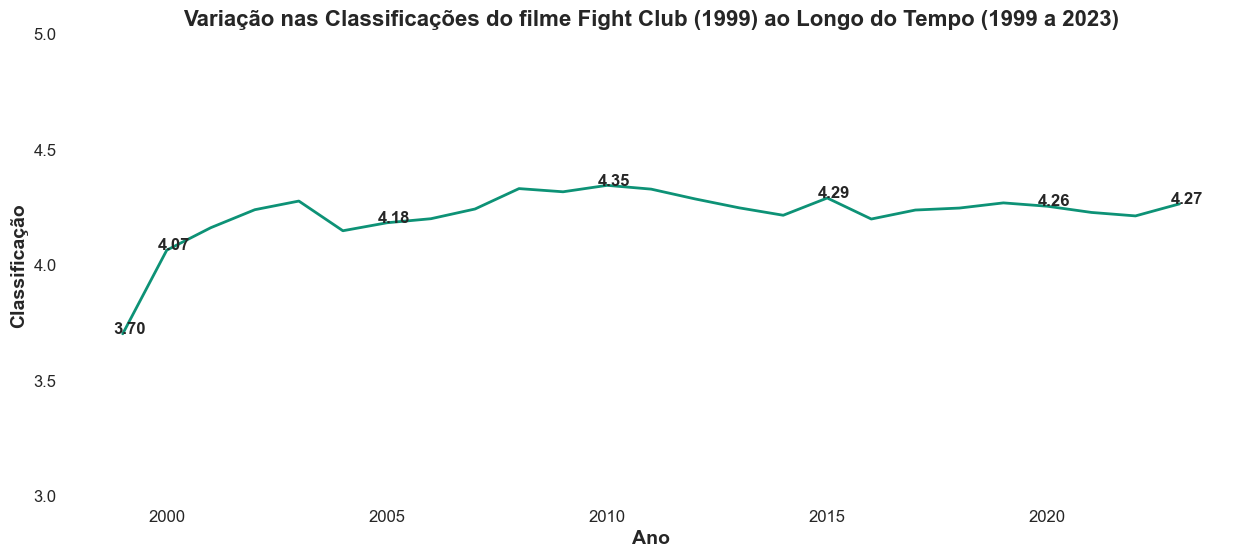

In [89]:
lineplot_rating_date_by_movieid(movieid=2959)

A análise dos dados do gráfico de linha para o filme **Fight Club (1999)** sugere que, ao longo do tempo, a média das classificações dos usuários tende a aumentar. Isso pode ser interpretado como um indicativo de que o filme tem ganhado reconhecimento e apreciação ao longo dos anos, indicando uma possível ascensão para o status de filme cult.

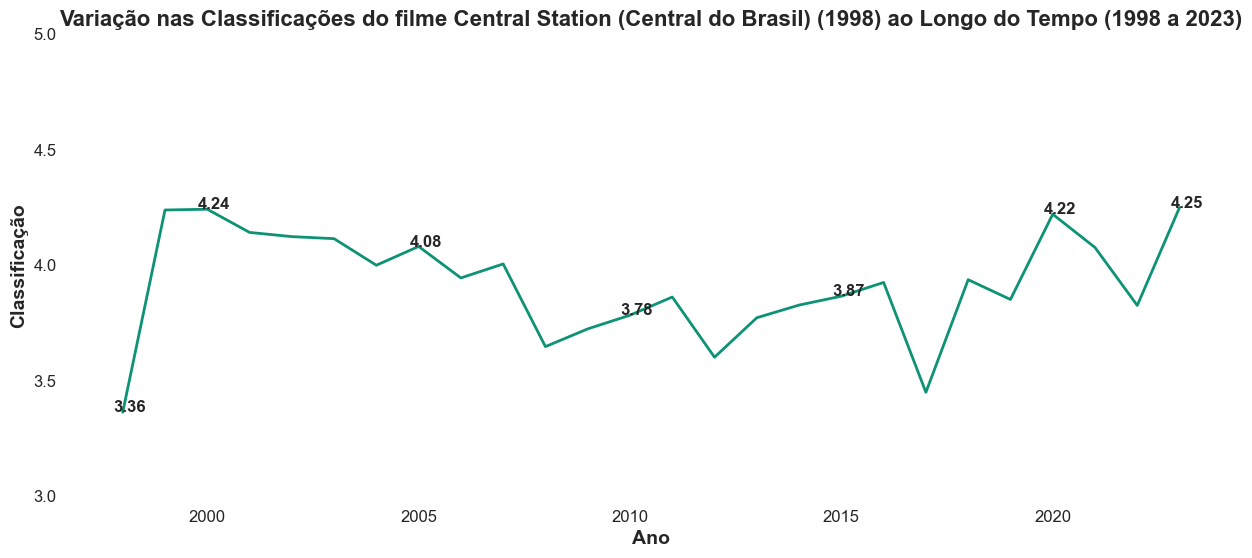

In [90]:
lineplot_rating_date_by_movieid(movieid=2357)

O filme **Central do Brasil** (1998) parece ter tido uma recepção inicial muito positiva em 1999, com uma média de 4.24, indicando um forte impacto emocional ou apreciação do público.

**Central do Brasil** é um filme brasileiro dirigido por Walter Salles, estrelado por Fernanda Montenegro e Vinícius de Oliveira. O filme é conhecido por sua narrativa emotiva e por abordar temas como a busca por identidade, conexões humanas e jornadas pessoais. Lançado em 1998, o filme foi indicado ao Oscar de Melhor Filme Estrangeiro e recebeu aclamação da crítica por suas performances, direção e narrativa poética.

## Análise de frequência de tags

In [91]:
def plot_wordcloud_by_year(min_year: int, max_year: int, max_words: int = 100,
                           export: bool = False, translate: bool = False):
  '''
  Plota uma nuvem de palavras para cada ano entre min_year e max_year
  min_year: ano inicial
  max_year: ano final
  max_words: quantidade maxima de palavras
  export: exportar resultado'''
  
  translator = Translator(to_lang="pt-br")
  
  def translate_text_to_pt_br(text: str, translation_dict: dict) -> str:  
    if text not in translation_dict:
        translation = translator.translate(text)
        translation_dict[text] = translation
    return translation_dict[text]
  
  SQL_200 = '''
    WITH most_count_tags AS (
      SELECT g.tagid
           , count(*) as count
      FROM genome_scores g
      JOIN movies m
        ON g.movieid = m.movieid
      WHERE 1=1
        AND m.year between {min_year} and {max_year}
        AND g.relevance >= 0.80
      GROUP BY g.tagid
      ORDER BY 2 DESC
      LIMIT {max_words}
    )
    SELECT t.tagid
         , TRIM(t.tag) as tag
      FROM genome_scores g
      JOIN genome_tags t
        ON g.tagid = t.tagid
      JOIN movies m
        ON g.movieid = m.movieid
      JOIN most_count_tags mc
        ON g.tagid = mc.tagid
      WHERE 1=1
        AND m.year between {min_year} and {max_year}
        AND g.relevance >= 0.80
        AND t.tag IS NOT NULL
    '''

  df_200 = spark.sql(SQL_200.format(max_words = max_words, min_year = min_year, max_year = max_year))
  print(f'Count: {df_200.count()}')
  df_200 = df_200.toPandas()

  translation_dict = {}  # Dicionário para armazenar as traduções

  if translate:
     df_200['tag'] = df_200['tag'].apply(lambda x: translate_text_to_pt_br(x, translation_dict))

  text = ' '.join(df_200['tag'])

  if export:
      with open(f'./export/{min_year}-{max_year}.txt', 'w') as f:
          f.write(text)

  wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=max_words).generate(text)

  # Plotar a WordCloud
  plt.figure(figsize=(10, 5))
  plt.title(f'Tags de filmes entre {min_year} e {max_year}')
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

Count: 1666


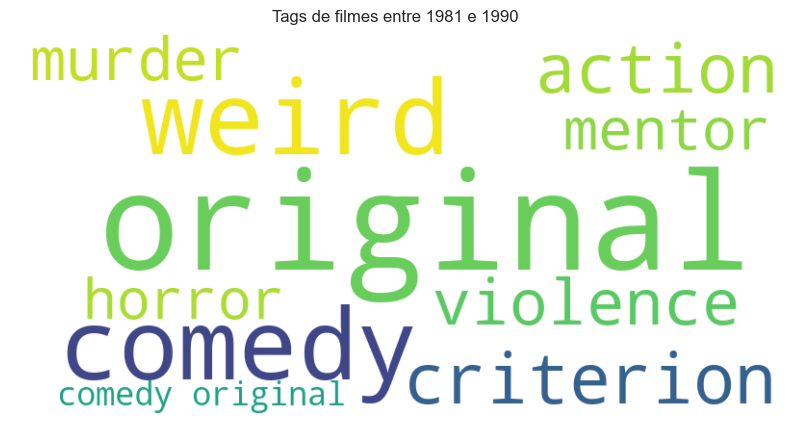

In [92]:
plot_wordcloud_by_year(min_year=1981, max_year=1990, max_words=10, translate=False)

Count: 2120


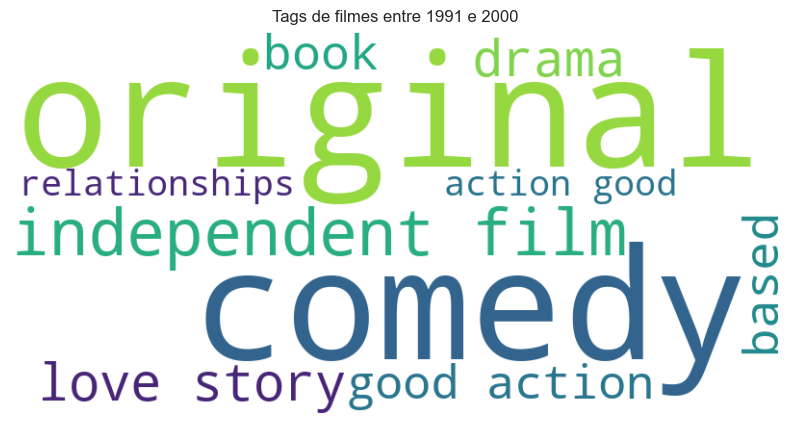

In [93]:
plot_wordcloud_by_year(min_year=1991, max_year=2000, max_words=10, translate=False)

Count: 3860


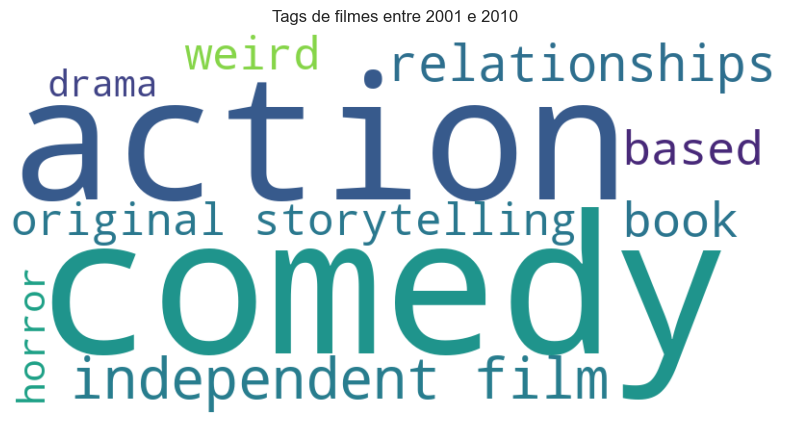

In [94]:
plot_wordcloud_by_year(min_year=2001, max_year=2010, max_words=10, translate=False)

Count: 3918


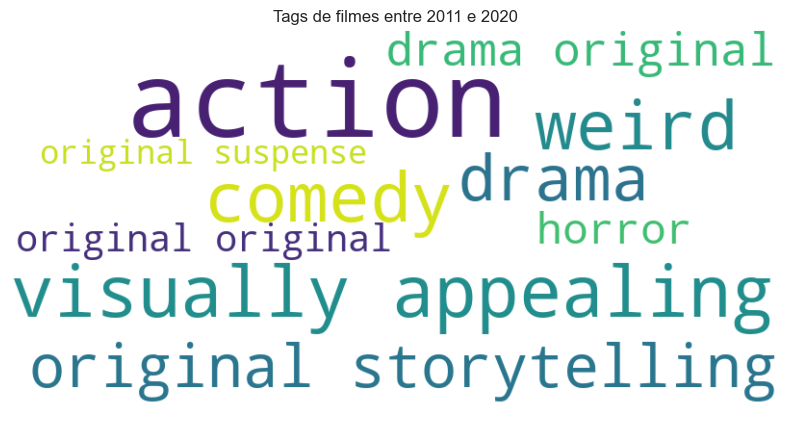

In [95]:
plot_wordcloud_by_year(min_year=2011, max_year=2020, max_words=10, translate=False)

Count: 436


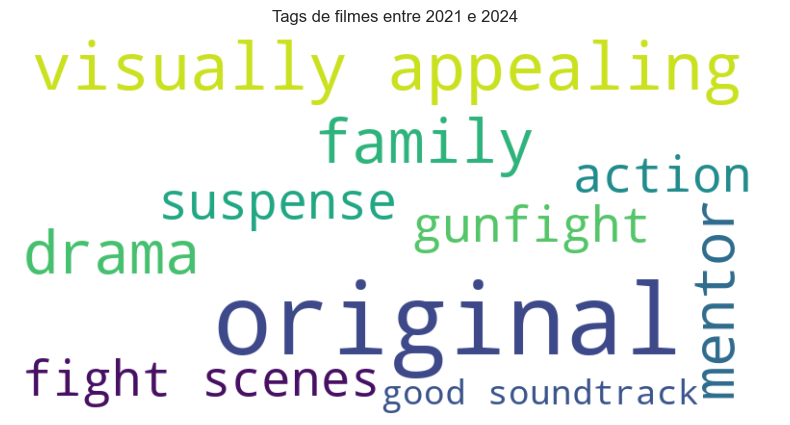

In [96]:
plot_wordcloud_by_year(min_year=2021, max_year=2024, max_words=10, translate=False)

# Distribuição de gêneros de filmes

In [97]:
SQL_300 = '''
SELECT m.year
     , m.genres
  FROM movies m
'''

df_300 = spark.sql(SQL_300)

df_301 = df_300.select("year", f.explode("genres").alias("genre"))\
                   .filter("genre <> '(no genres listed)'")

df_301 = df_301.withColumn('decade', f.concat(f.substring(df_301['year'], 1, 3), f.lit("0's")))

df_301.show(5, False)

+----+---------+------+
|year|genre    |decade|
+----+---------+------+
|1995|Adventure|1990's|
|1995|Animation|1990's|
|1995|Children |1990's|
|1995|Comedy   |1990's|
|1995|Fantasy  |1990's|
+----+---------+------+
only showing top 5 rows



In [98]:
df_301.createOrReplaceTempView("df301")

In [99]:
SQL_302 = '''
SELECT DISTINCT
    decade,
    genre,
    genre_rank,
    ROUND(SUM(percent) OVER (PARTITION BY decade ORDER BY genre_rank DESC), 2) AS percent_acumulative
FROM (
    SELECT 
        decade,
        qt_all_movies,
        CASE WHEN genre_rank <= 5 THEN genre ELSE 'Others' END AS genre,
        qt_genre_movies,
        percent,
        CASE WHEN genre_rank <= 5 THEN genre_rank ELSE -1 END AS genre_rank
    FROM (
        SELECT 
            d1.decade,
            d2.qt_all_movies,
            d1.genre,
            COUNT(1) AS qt_genre_movies,
            ROUND(COUNT(1) * 100.0 / d2.qt_all_movies, 2) AS percent,
            DENSE_RANK() OVER (PARTITION BY d1.decade ORDER BY COUNT(1) DESC) AS genre_rank
        FROM df301 d1
        JOIN (
            SELECT 
                decade,
                COUNT(1) AS qt_all_movies
            FROM df301
            WHERE decade IS NOT NULL
            GROUP BY decade
            HAVING COUNT(1) > 100 -- qtd mínima de filmes por década
        ) d2 ON d1.decade = d2.decade
        GROUP BY d1.decade, d1.genre, d2.qt_all_movies
    ) ranked_genres
) ranked_genres_acumulative
ORDER BY 1, 3
'''


df_302 = spark.sql(SQL_302)

df_302.show(18, truncate = False)

+------+-----------+----------+-------------------+
|decade|genre      |genre_rank|percent_acumulative|
+------+-----------+----------+-------------------+
|1890's|Others     |-1        |100.00             |
|1890's|Documentary|1         |91.09              |
|1890's|Comedy     |2         |29.31              |
|1890's|Fantasy    |3         |18.48              |
|1890's|Horror     |4         |9.56               |
|1890's|Drama      |5         |4.46               |
|1900's|Others     |-1        |99.99              |
|1900's|Comedy     |1         |79.46              |
|1900's|Fantasy    |2         |51.78              |
|1900's|Documentary|3         |25.89              |
|1900's|Drama      |4         |14.88              |
|1900's|Horror     |5         |5.95               |
|1910's|Others     |-1        |100.00             |
|1910's|Comedy     |1         |77.48              |
|1910's|Drama      |2         |44.42              |
|1910's|Romance    |3         |18.05              |
|1910's|Fant

In [100]:
df_301 = df_301.toPandas()

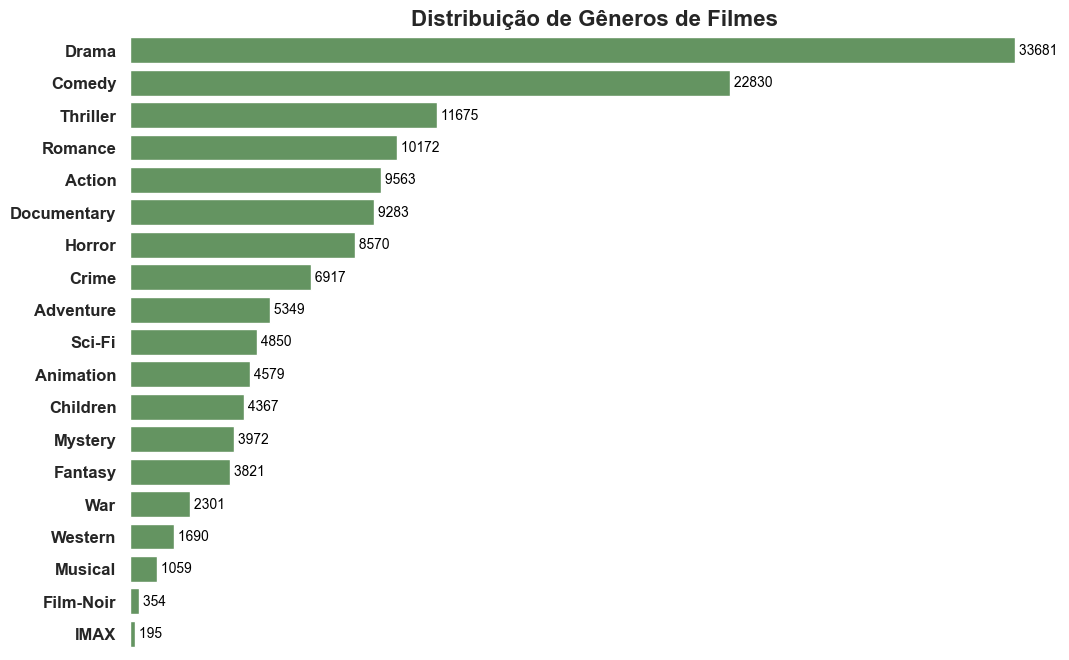

In [101]:
# Calcular as contagens de cada gênero
genre_counts = df_301['genre'].value_counts()

# Criar o gráfico de distribuição
plt.figure(figsize=(12, 8))
ax = sns.countplot(y='genre', data=df_301, color='#5D9C59', order=genre_counts.index)


# Adicionar rótulos e título ao gráfico
plt.xlabel('')
plt.ylabel('')
plt.title('Distribuição de Gêneros de Filmes', fontsize = 16, fontweight='bold')

# Remover os valores do eixo x
ax.set_xticks([])

plt.yticks(fontweight='bold')

# Adicionar anotações dentro das barras com uma margem
for index, value in enumerate(genre_counts):
    ax.text(value, index, f' {value}', ha='left', va='center', fontsize=10, color='black')

plt.show()

#### Drama é o Gênero Mais Prevalente
O gênero Drama lidera a distribuição, representando a maior quantidade de filmes no conjunto de dados. Essa predominância sugere a popularidade contínua de dramas ao longo dos anos e destaca seu apelo amplo ao público.

#### Comédia e Thriller Também Têm Presença Significativa
Comédia e Thriller ocupam as posições de segundo e terceiro gêneros mais prevalentes, respectivamente. Isso indica que esses gêneros têm uma base de fãs sólida e são frequentemente explorados pela indústria cinematográfica para atrair diferentes públicos.

#### Gêneros Específicos e de Nicho
Gêneros menos comuns, como Film-Noir e IMAX, têm representações menores. Isso sugere que esses gêneros são mais específicos e podem atrair um público de nicho, indicando uma abordagem mais seletiva na produção desses filmes.

In [102]:
df312 = df_302.toPandas()

In [103]:
genre_colors = {
    'Animation': '#3498db',    # Azul claro para representar a leveza da animação
    'Documentary': '#4f3011',  # marron associado à seriedade e autenticidade documental
    'Others': '#95a5a6',       # Cinza suave para representar categorias diversas agrupadas
    'Comedy': '#f39c12',       # Amarelo vivo, comum em gêneros leves e engraçados
    'Fantasy': '#8e44ad',      # Roxo profundo associado a elementos fantásticos e mágicos
    'Horror': '#000000',        # Preto, comum em gêneros de terror e suspense
    'Drama': '#fd5d3d',        # Vermelho mais claro para representar dramas emocionais
    'Romance': '#d9d99b',      # Bege associado a tons românticos
    'Western': '#f1c40f',      # Amarelo quente relacionado a configurações do Velho Oeste
    'Adventure': '#2ecc71',    # Verde vibrante associado a aventuras e exploração
    'Crime': '#191970',        # Azul escuro relacionado a elementos criminais e de suspense
    'Action': '#ab0000',       # Vermelho mais escuro, comum em gêneros de ação
    'Thriller': '#2F4F4F'      # Verde mais escuro para representar emoção e suspense
}

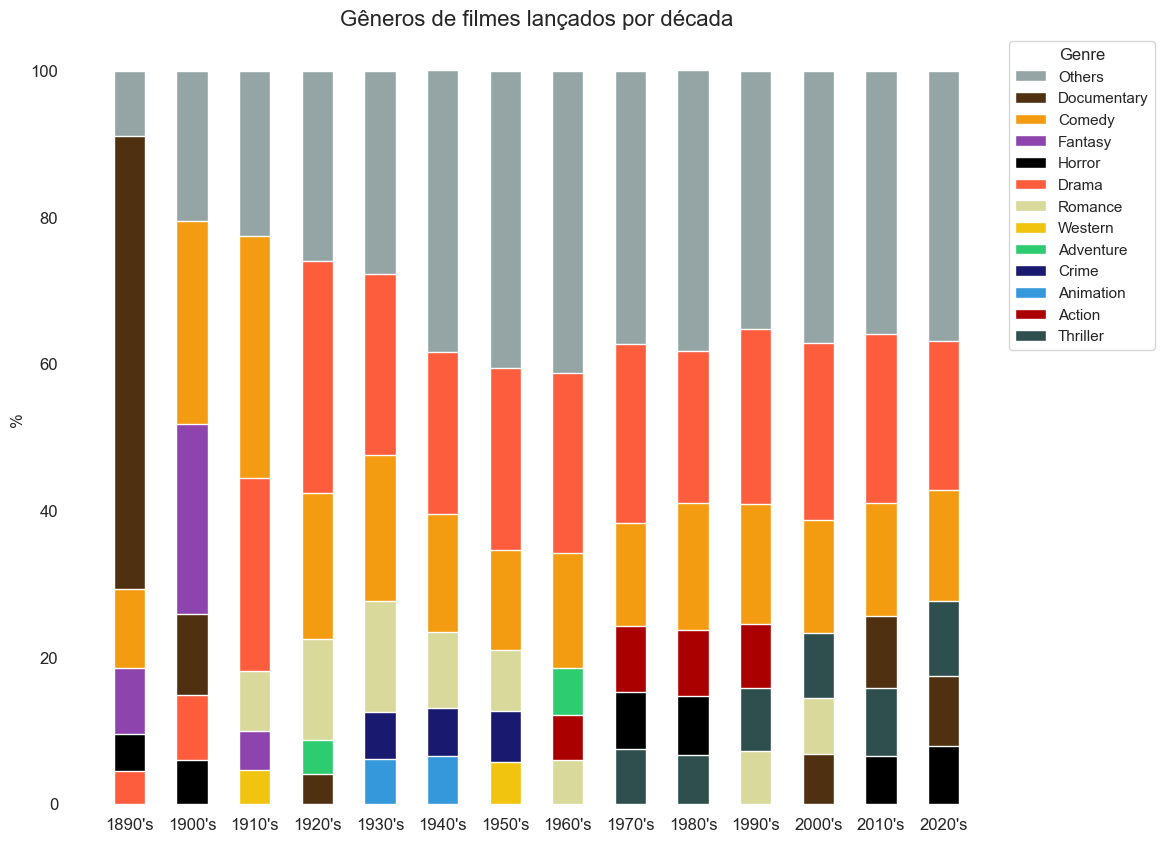

In [104]:
# Adicionar uma coluna numérica para representar a ordem da década
df312['decade_order'] = df312['decade'].str.extract('(\d+)').astype(int)

plt.figure(figsize=(12, 10))

# Dicionário para armazenar a ordem dos gêneros por década
genre_orders = dict()

# Obter a ordem dos gêneros para cada década
for decade in df312['decade_order'].unique():
    genre_order = df312[df312['decade_order'] == decade]['genre'].unique().tolist()
    genre_orders[decade] = genre_order

# Dicionário para armazenar a contagem de gêneros para a legenda
genre_json = {}

# Loop sobre décadas
for decade in df312['decade_order'].unique():
    genre_order = genre_orders[decade]

    # Loop sobre gêneros para adicionar barras empilhadas
    for genre in genre_order:
        # Filtrar dados para o gênero específico e década específica
        genre_data = df312.query("genre == @genre and decade_order == @decade")

        # Adicionar barras ao gráfico
        bars = plt.bar(
            genre_data['decade_order'],
            genre_data['percent_acumulative'],
            color=genre_colors.get(genre, 'gray'),  # Usar a cor associada ao gênero ou 'gray' como padrão
            width=5
        )

        # Atualizar o dicionário de contagem de gêneros para a legenda
        if genre not in genre_json:
            genre_json[genre] = 1
        else:
            genre_json[genre] += 1

        # Adicionar rótulo para cada gênero
        for bar in bars:
            if genre_json[genre] == 1:
                bar.set_label(genre)

# Adicionar rótulos e título ao gráfico
plt.xlabel('')
plt.ylabel('%')
plt.title('Gêneros de filmes lançados por década', fontsize=16)
plt.xticks(ticks=df312['decade_order'].unique(), labels=df312['decade'].unique())

plt.legend(title='Genre', bbox_to_anchor=(1, 1))
plt.show()

<b>O ranking de gêneros é baseado no percentual acumulado, indicando quais gêneros têm maior representação ao longo do tempo.
Diferenças nas preferências do público ao longo das décadas podem ser observadas, refletindo mudanças culturais e sociais.</b>

#### Comedy e Drama
Comedy e Drama são os gêneros mais consistentes ao longo das décadas.
A presença significativa desses gêneros é observada desde as décadas mais antigas até as mais recentes, destacando sua popularidade contínua.

#### Documentários
Documentários tiveram uma presença modesta nas primeiras décadas, mas houve um aumento notável a partir dos anos 2000.
A década de 2000 marca uma virada, com Documentários ocupando o 5º lugar em percentual acumulado, indicando um interesse crescente nesse gênero.

#### Action
Action é um gênero proeminente nas décadas entre 1970 e 1990.
Sua presença na década de 1960 também é notável. Contudo, a partir dos anos 2000, há uma queda em sua classificação, sugerindo uma mudança de preferência de gênero de filmes de ação.

#### Outros Gêneros Relevantes
Além dos destaques mencionados, outros gêneros como Thriller, Horror e Romance também têm presença constante ao longo das décadas, embora com variações em suas classificações.

## Classificações para diferentes gêneros de filmes

In [105]:
SQL_400 = '''
SELECT r.rating, m.genres
  FROM ratings r
  JOIN movies m
    ON r.movieid = m.movieid
'''

df_400 = spark.sql(SQL_400)
df_400 = df_400.select("rating", f.explode("genres").alias("genre"))\
               .filter(f.col("genre") != "(no genres listed)")
df_400 = df_400.groupBy("genre")\
               .agg(f.avg("rating").alias("rating"))\
               .orderBy("rating", ascending=False)
df_400.show(10, truncate=False)

+-----------+-------+
|genre      |rating |
+-----------+-------+
|Film-Noir  |3.91596|
|War        |3.79758|
|Crime      |3.69720|
|Documentary|3.69260|
|Drama      |3.68584|
|Mystery    |3.67403|
|Animation  |3.61556|
|IMAX       |3.60687|
|Western    |3.59565|
|Musical    |3.54809|
+-----------+-------+
only showing top 10 rows



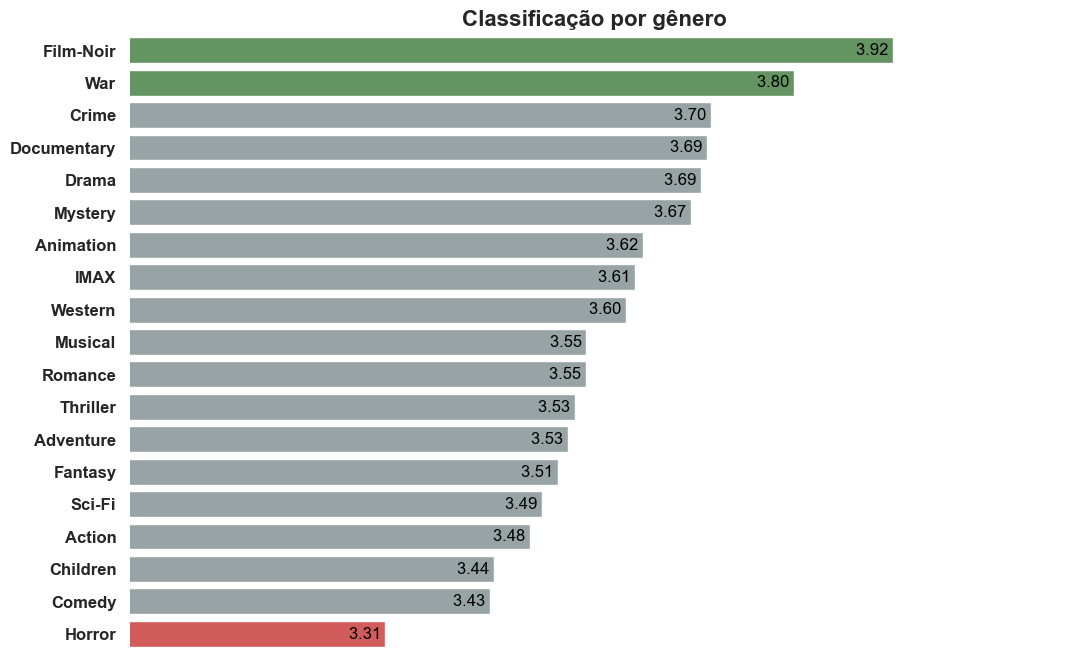

In [106]:
colors = ['#5D9C59', '#5D9C59',
          '#95a5a6', '#95a5a6', '#95a5a6', '#95a5a6', '#95a5a6',
          '#95a5a6', '#95a5a6', '#95a5a6', '#95a5a6', '#95a5a6',
          '#95a5a6', '#95a5a6', '#95a5a6', '#95a5a6', '#95a5a6', '#95a5a6',
          '#E64848']


plt.figure(figsize=(12, 8))

ax = sns.barplot(x='rating', y='genre', data=df_400.toPandas(), palette = colors, hue='genre', legend=False)

plt.yticks(fontweight='bold')  # Legendas do eixo y em negrito

plt.title('Classificação por gênero', fontweight='bold', fontsize = 16)  # Título em negrito

plt.xlabel('')  # Rótulo do eixo x em negrito
plt.ylabel('')  # Rótulo do eixo y em negrito

ax.set_xticks([])

# Definir limite inferior para o eixo x
ax.set_xlim(3, float(max(df_400.toPandas()['rating'])) + 0.2)

# Exibir o valor dentro da barra
for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f} ', (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='right', va='center', color='black')

plt.show()

#### Film-Noir e War
**Film-Noir:** Com uma classificação de 3.92, Film-Noir é o gênero com a classificação mais alta na lista. Isso sugere que os filmes classificados como Film-Noir são geralmente bem recebidos pelos espectadores, indicando uma apreciação significativa por esse tipo de filme.
**War:** Logo abaixo, War possui uma classificação de 3.80, a segunda mais alta. Isso indica que os filmes de guerra também são bem avaliados pelos espectadores, sugerindo uma forte recepção para esse gênero.

#### Horror
Com uma classificação de 3.31, **Horror** é o gênero com a classificação mais baixa. Isso sugere que os filmes de horror podem não ser tão bem recebidos em comparação com outros gêneros listados. Os espectadores tendem a dar pontuações mais baixas para filmes de horror, indicando uma recepção menos favorável para esse tipo de filme.

## Informações sobre ratings

In [107]:
SQL_500 = '''
SELECT m.movieid
     , count(1)      as qtd_ratings
  FROM ratings r
  JOIN movies m
    ON r.movieid = m.movieid
 GROUP BY m.movieid
'''

df_500 = spark.sql(SQL_500)
df_500.show(10, truncate=False)
df_500.count()

+-------+-----------+
|movieid|qtd_ratings|
+-------+-----------+
|474    |21161      |
|106100 |10797      |
|6721   |1103       |
|72011  |8741       |
|29     |10445      |
|106002 |5628       |
|60756  |6736       |
|207297 |75         |
|4823   |5611       |
|1950   |4325       |
+-------+-----------+
only showing top 10 rows



83239

In [108]:
df_510 = df_500.toPandas()

df_510['qtd_ratings'].describe()\
                     .astype('int')

count     83239
mean        406
std        2806
min           1
25%           2
50%           5
75%          26
max      122296
Name: qtd_ratings, dtype: int32

In [109]:
print('O dataset contém {} filmes.'.format(df_510.shape[0]))
print('{} filmes contém 1 avaliação.'.format(df_510[df_510["qtd_ratings"] == 1].shape[0]))
print('{} filmes contém 2 avaliações.'.format(df_510[df_510["qtd_ratings"] == 2].shape[0]))
print('{} filmes contém 3 avaliações ou mais.'.format(df_510[df_510["qtd_ratings"] >= 3].shape[0]))
print('{} filmes contém 5 avaliações ou mais.'.format(df_510[df_510["qtd_ratings"] >= 5].shape[0]))
print('{} filmes contém 10 avaliações ou mais.'.format(df_510[df_510["qtd_ratings"] >= 10].shape[0]))
print('{} filmes contém 50 avaliações ou mais.'.format(df_510[df_510["qtd_ratings"] >= 50].shape[0]))
print('{} filmes contém 100 avaliações ou mais.'.format(df_510[df_510["qtd_ratings"] >= 100].shape[0]))
print('{} filmes contém mais avaliações do que a média ({})'.format(df_510[df_510["qtd_ratings"] >= df_510["qtd_ratings"].mean()].shape[0],
                                                                    df_510["qtd_ratings"].mean().astype('int')))

O dataset contém 83239 filmes.
17916 filmes contém 1 avaliação.
10161 filmes contém 2 avaliações.
55162 filmes contém 3 avaliações ou mais.
43873 filmes contém 5 avaliações ou mais.
32021 filmes contém 10 avaliações ou mais.
16116 filmes contém 50 avaliações ou mais.
12253 filmes contém 100 avaliações ou mais.
6929 filmes contém mais avaliações do que a média (406)


In [110]:
spark.stop()